Task1_0722. Adult Income 데이터셋을 이용한 전처리 및 분류 모델(소득이 50K 이상인지 예측)을 아래 설명을 참조하여 수행하세요.

[ 문제 설명 ]

- Adult Income 데이터셋을 로드합니다.
- 결측치를 처리합니다.
- 이상치를 제외합니다.
- 파생 변수를 작성합니다.
- 범주형 변수를 인코딩합니다.
- 변수 선택 및 독립변수 종속변수를 분리합니다.
- 데이터를 표준화합니다.
- 데이터셋을 학습용과 테스트용으로 나눕니다.
- Logistic Regression 모델 생성 및 학습합니다.
- 예측 및 평가합니다.

In [55]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# 1. 데이터 로드
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']

# na_values = ? 는 ?로 되어있는 값들을 None값으로 처리한다는 의미
data = pd.read_csv(url, header=None, names=columns, na_values='?', skipinitialspace=True)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [57]:
# 범주형 변수 인코딩
data['sex'] = data['sex'].map({'Male': 0, 'Female': 1})

# 파생변수1 : age_group
data['age_group'] = pd.cut(data['age'], bins=[0, 18, 30, 45, 60, 100], labels=['0-18', '19-30', '31-45', '46-60', '61+'])

# 파생변수2 : hours_group
data['hours_group'] = pd.cut(data['hours-per-week'], bins=[0, 20, 40, 60, 100], labels=['0-20', '21-40', '41-60', '61+'])

# 파생변수3 : capital
data['capital'] = data['capital-gain'] - data['capital-loss']

# 불필요 컬럼 제거
#data = data.drop(columns=['capital-gain', 'capital-loss', 'native-country'])
data.drop(columns=['occupation', 'fnlwgt', 'education-num', 'capital-gain',
  'capital-loss', 'native-country', 'workclass', 'education', 'marital-status', 'relationship'], inplace=True)


In [71]:
data.head()

,age,race,sex,hours-per-week,income,age_group,hours_group,capital,workclass_simple,continent
0,39,4,0,40,<=50K,2,1,2174,0,3
1,50,4,0,13,<=50K,3,0,0,2,3
2,38,4,0,40,<=50K,2,1,0,2,3
3,53,2,0,40,<=50K,3,1,0,2,3
4,28,2,1,40,<=50K,1,1,0,2,2


In [61]:
# 범주형 변수 값을 레이블 인코딩으로 이진벡터로 변환

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['race'] = label_encoder.fit_transform(data['race'])

data['age_group'] = label_encoder.fit_transform(data['age_group'])
data['hours_group'] = label_encoder.fit_transform(data['hours_group'])

In [56]:
# 범주형 변수 race (인종) 값을 one-hot 인코딩으로 이진벡터로 변환

from sklearn.preprocessing import OneHotEncoder

# One-Hot Encoding 적용
onehot_encoder = OneHotEncoder(sparse_output=False)
encoded_data = onehot_encoder.fit_transform(data[['race']])

# 결과를 DataFrame으로 변환
encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoder.get_feature_names_out(['race']))

# 원래 데이터프레임에 추가
df = pd.concat([data, encoded_df], axis=1)
df

,age,fnlwgt,education-num,race,sex,capital-gain,capital-loss,hours-per-week,income,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,77516,13,White,0,2174,0,40,<=50K,0.0,0.0,0.0,0.0,1.0
1,50,83311,13,White,0,0,0,13,<=50K,0.0,0.0,0.0,0.0,1.0
2,38,215646,9,White,0,0,0,40,<=50K,0.0,0.0,0.0,0.0,1.0
3,53,234721,7,Black,0,0,0,40,<=50K,0.0,0.0,1.0,0.0,0.0
4,28,338409,13,Black,1,0,0,40,<=50K,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,White,1,0,0,38,<=50K,0.0,0.0,0.0,0.0,1.0
32557,40,154374,9,White,0,0,0,40,>50K,0.0,0.0,0.0,0.0,1.0
32558,58,151910,9,White,1,0,0,40,<=50K,0.0,0.0,0.0,0.0,1.0
32559,22,201490,9,White,0,0,0,20,<=50K,0.0,0.0,0.0,0.0,1.0


MED : 178356.0
MIN : 12285
MAX : 1484705


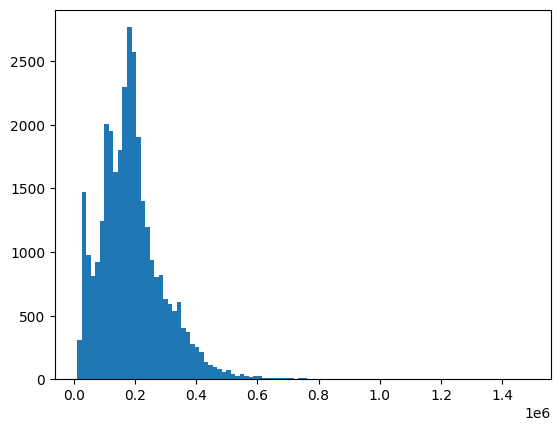

In [43]:
# fnlwgt 특정 개인이나 그룹이 전체 인구에서 얼마나 큰 비중을 차지하고 있는지를 나타낸다.
# 어떤 개인의 fnlwgt가 1,000이라면, 이는 이 개인이 1,000의 사람들을 대표한다는 의미이다.
# 현재의 데이터에서는 fnlwgt가 0인 데이터는 존재하지 않는다.

import matplotlib.pyplot as plt
import seaborn as sns

med = df.fnlwgt.median()
min = df.fnlwgt.min()
max = df.fnlwgt.max()

print(f"MED : {med}")
print(f"MIN : {min}")
print(f"MAX : {max}")

# df.fnlwgt 데이터들을 가지고 히스토그램 시각화를 해보자
plt.hist(df.fnlwgt, bins=100)
plt.show()


In [72]:
from sklearn.linear_model import LogisticRegression

# 데이터 분리
X = data.drop('income', axis=1)
y = data['income']

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 모델 초기화 및 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.79
